In [189]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.datasets import make_blobs
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import expit

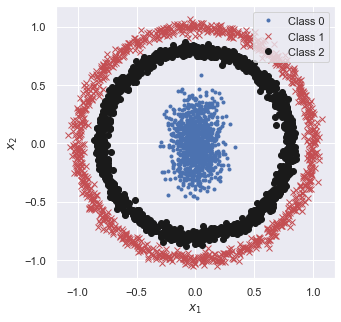

In [190]:
df = pd.read_csv('threeConcentricClasses.csv', header=None)

x1 = df[0].to_numpy()
x2 = df[1].to_numpy()
y = df[2].to_numpy()

x1 = x1.reshape(len(x1),1)
x2 = x2.reshape(len(x2),1)
x = np.c_[x1,x2]
              
idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)
idx2 = np.argwhere(y == 2)

fig = plt.figure(figsize=(5,5))
plt.plot(x[idx0,0], x[idx0,1], '.', label='Class 0')
plt.plot(x[idx1,0], x[idx1,1], 'rx', label='Class 1')
plt.plot(x[idx2,0], x[idx2,1], 'ko', label='Class 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In [191]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

def error_function(x, a, y, epsilon=1e-7):    
    logits = x.dot(a)
    y_prob = softmax(logits)
    error = -np.mean(np.sum(y * np.log(y_prob + epsilon), axis=1))
    return error

def classifier(x, a):
    logits = x.dot(a)
    y_prob = softmax(logits)
    c = np.zeros((len(y_prob), 1))
    for i in range(0, len(y_prob)):
        c[i, 0] = np.argwhere(y_prob[i,:] == y_prob[i,:].max())[0]
    return c

def predict_prob(x, a):
    logits = x.dot(a)
    y_prob = softmax(logits)
    h1 = y_prob
    h0 = 1 - h1
    h = np.c_[h0, h1]
    return h

In [192]:
# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=12)

x_train = np.c_[np.ones((len(y_train), 1)), x_train**2]

x_test = np.c_[np.ones((len(y_test), 1)), x_test**2]

y_train = to_one_hot(y_train)

Y_test = y_test

y_test = to_one_hot(y_test)

In [193]:
# Batch gradient descent solution.

# learning rate.
alpha = 3.00
# Maximum number of iterations.
n_iterations = 5000

epsilon = 1e-7

# Random initialization of parameters.
a = np.random.randn(x_train.shape[1], y_train.shape[1])

# Create array for storing error values.
Jgd = np.zeros(n_iterations+1)
Jgd_v = np.zeros(n_iterations+1)

# Calculate initial error.
Jgd[0] = error_function(x_train, a, y_train, epsilon)
Jgd_v[0] = error_function(x_test, a, y_test, epsilon)

# Batch gradient-descent loop.
minimum_val_error = float("inf")
iteration = 0
error = 1
while iteration < n_iterations:
    logits = x_train.dot(a)
    y_prob = softmax(logits)
    gradients = 1/len(y_train)*x_train.T.dot(y_prob - y_train)
    a = a - alpha*gradients
    Jgd[iteration+1] = error_function(x_train, a, y_train, epsilon)
    Jgd_v[iteration+1] = error_function(x_test, a, y_test, epsilon)
    error = np.abs(Jgd[iteration+1] - Jgd[iteration])
    if(Jgd_v[iteration+1] < minimum_val_error):
        minimum_val_error = Jgd_v[iteration+1]
        a_min = a        
    iteration = iteration + 1

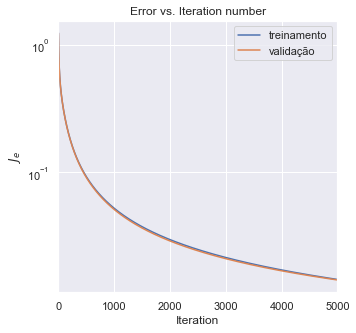

In [194]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

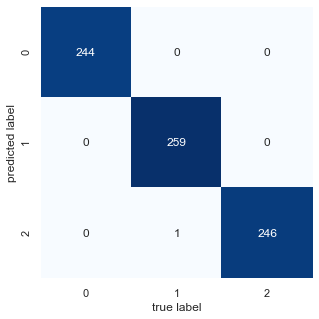

In [195]:
y_pred_class = classifier(x_test, a_min)

# Plot the confusion matrix
fig = plt.figure(figsize=(5,5))
mat = confusion_matrix(Y_test, y_pred_class)
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['0','1','2'], yticklabels=['0','1','2'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

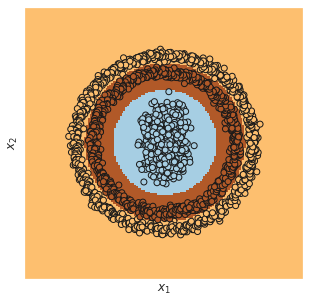

In [199]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = classifier(np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel()**2, yy.ravel()**2], a_min)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(5, 5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())


plt.show()

In [197]:
print(classification_report(Y_test, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       1.00      1.00      1.00       260
           2       1.00      1.00      1.00       246

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



In [198]:
print(accuracy_score(Y_test, y_pred_class))

0.9986666666666667
